# Learning Objectives

- Understand the following key abstractions to implement generative AI agents using `crewai`:
    - Reasoning
    - Tools
    - Memory

# Setup

In [19]:
import os
# Standard Python library for interacting with the operating system (env variables, file paths, etc.)

from crewai import LLM, Agent, Task, Crew, Process
# Core classes from CrewAI:
# - LLM: Wrapper to connect to a language model (e.g., GPT, Claude, etc.)
# - Agent: An autonomous entity that can take tasks, use tools, and make decisions
# - Task: A unit of work or objective given to an agent
# - Crew: A collection (or team) of agents working together on tasks
# - Process: Defines how the crew executes tasks (sequential, hierarchical, etc.)

from crewai.tools import tool
# Decorator/function to register a custom function as a "tool" that agents can use.

from crewai.memory import ShortTermMemory, EntityMemory
# Memory modules for agents:
# - ShortTermMemory: Stores recent interactions in context (like conversation history).
# - EntityMemory: Stores facts/entities about people, places, or objects across interactions.

from crewai.memory.storage.rag_storage import RAGStorage
# RAG (Retrieval-Augmented Generation) storage backend,
# used for storing and retrieving documents to enhance agent reasoning with external knowledge.

from langchain_community.tools.tavily_search import TavilySearchResults
# A community-built LangChain tool for search via the Tavily API,
# useful when agents need fresh web knowledge or search capabilities.

from dotenv import load_dotenv
# Loads environment variables from a `.env` file into the program.
# Typically used to manage API keys and config securely without hardcoding them.

def warnings_off():
    import warnings
    warnings.filterwarnings('ignore')

In [15]:
os.environ['TAVILY_API_KEY'] = os.getenv('tavily_search_api_key')
azure_api_key = os.getenv('azure_api_key')
# Modify the Azure Endpoint and the API Versions as needed
azure_base_url = os.getenv('azure_base_url')
azure_api_version = os.getenv('azure_api_version')
os.environ["CHROMA_OPENAI_API_KEY"] = azure_api_key

In [4]:
llm = LLM(
    model = 'azure/gpt-4o-mini',
    api_base = azure_base_url,
    api_key = azure_api_key,
    api_version = azure_api_version,
    temperature = 0
)

# Business Objective

Develop an intelligent conversational agent capable of answering user queries accurately and effectively. The agent should leverage its internal knowledge but also dynamically access external, up-to-date information via web search (using Tavily Search) when necessary to provide comprehensive and current responses. This ensures users receive relevant answers even for topics beyond the agent's static training data, making it suitable for roles like research assistance, complex question answering, or providing current event summaries. The agent must maintain conversation history to understand context across multiple interactions.

# Implementation Plan

In this notebook, we implement a single-agent Crew designed to function as an expert research analyst. The goal is to take a user's query, understand its requirements, and provide a comprehensive answer. The implementation leverages CrewAI's core abstractions:

- Tool Definition: A specific tool (`tavily_search`) is defined using the @tool decorator, allowing the agent to perform external web searches via Tavily. This encapsulates the action/tool use capability.
- Agent Definition: An Agent (`researcher`) is configured with a specific role, goal, and backstory. These prompts, combined with the assigned LLM (`llm`), guide the agent's reasoning process - deciding how to approach the task and whether to use its assigned tool. The tool is explicitly linked to the agent. Memory capabilities are enabled.

- Task Definition: A Task (`research_task`) is created, providing a detailed description of the work the agent needs to perform based on the user's input. This description further shapes the agent's reasoning and clarifies the expected output.

- Memory Configuration: The Crew is explicitly configured with to store and retrieve relevant information from past interactions or extracted entities using vector embeddings.

- Crew Orchestration: A Crew object (`research_crew`) assembles the agent and task. It manages the execution flow (sequentially, in this case) and orchestrates the interplay between the agent's reasoning, tool use, and memory access to accomplish the task.
Execution: The `crew.kickoff()` method initiates the process, feeding the user input into the defined task and triggering the agent's execution cycle.

# Configuring a Search Tool

As an example we attach the Tavily Search API as a tool to our LLM. Please visit Tavily to create your API key.

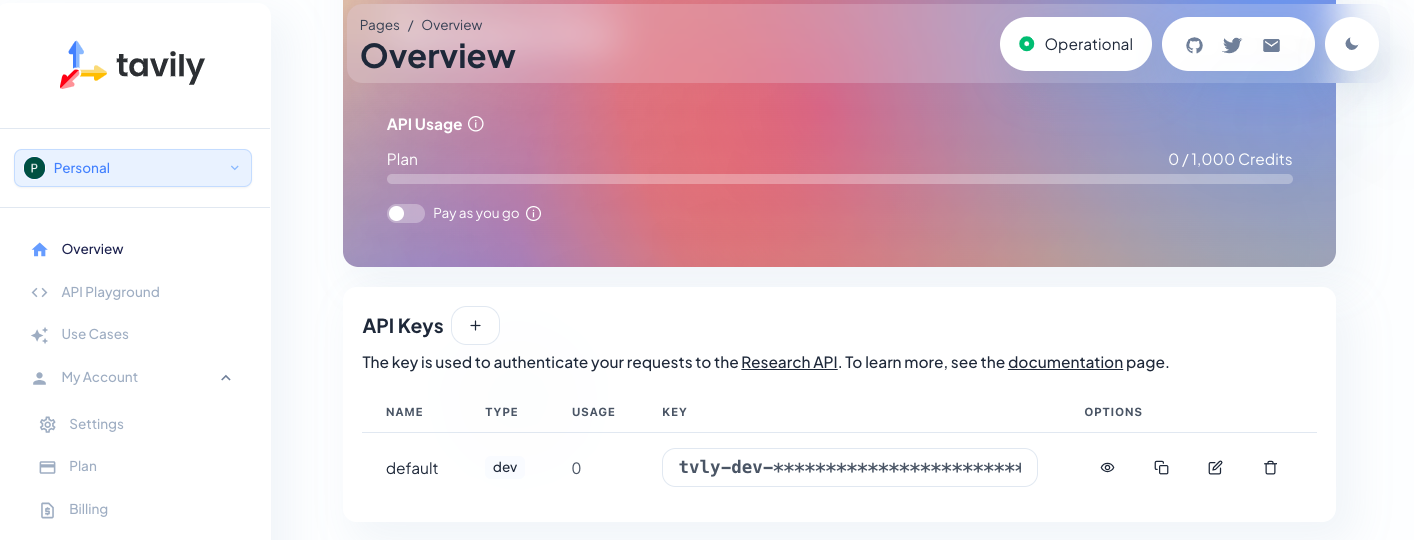

We will use the TavilySearchTool from LangChain but customize it to be compatible with Crew AI.

In [ ]:
# Initialize the Tavily search tool (LangChain wrapper)
# - max_results=5 → limits the number of search results returned
# You could increase/decrease this depending on how much info your agent needs

tavily_search_tool = TavilySearchResults(max_results=5)

C:\Users\Zenbook\AppData\Local\Temp\ipykernel_2872\3207579372.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(max_results=5)


In [7]:
@tool("search_tool")  
# Registers this function as a CrewAI tool with the name "search_tool".
# Agents can now discover and call it when they need to perform a search.

def tavily_search(query: str) -> str:
    """Search and return results using the Tavily search API"""  
    # Function takes a search query string and returns combined results as text.

    final_output = ''  
    # Initialize an empty string to store concatenated search results.

    # Call the Tavily search tool (LangChain wrapper), which returns a list of results.
    for result in tavily_search_tool.invoke(query):  
        # Each result is a dictionary with keys like "content".
        final_output += result['content']  
        # Append the content from each result to the final output string.

    return final_output  
    # Return the aggregated results back to the agent.


The above code block defines the tool the agent can use.
- First, an instance of the LangChain TavilySearchResults tool is created (`tavily_search_tool`).
- Then, a standard Python function `tavily_search` is defined. This function takes a query string, uses the `tavily_search_tool` instance to perform the search (`invoke`), processes the list of dictionary results to concatenate the 'content' into a single string (`final_output`), and returns that string.

CrewAI Abstraction (`@tool("search_tool")`): The `@tool` decorator is crucial. It registers the tavily_search Python function as a tool usable by CrewAI agents.

- The string "search_tool" passed to the decorator becomes the name the LLM will use when it decides to call this tool.

- The function's docstring ("""Search and return...""") serves as the description provided to the LLM, explaining what the tool does.
- The function's type hints (query: str -> str) inform the LLM about the expected input and output types.

In this way, this above code block illustrates the capability to use custom tools with the agent within Crew AI.

# Assembling the Agent and Crew

Let us now define a single agent in our crew. In Crew AI, the `Agent` class represents an autonomous unit with specific capabilities and objectives. Let us look at the key parameters of the `Agent` class defined below:

- `role`, `goal`, `backstory`: These parameters are essentially prompts that define the agent's persona, objectives, and operational guidelines. They heavily influence the LLM's reasoning process when this agent is active. The LLM uses this context to decide how to approach the task and whether using a tool is appropriate.

- `verbose=True`: Enables detailed logging of the agent's thought process and actions during execution, useful for debugging and understanding its reasoning.

- `allow_delegation=False`: Specifies that this agent cannot delegate tasks to other agents (relevant in multi-agent crews).

- `tools=[tavily_search]`: Assigns the list of available tools (our decorated tavily_search function) to this specific agent. This directly links the Tool Use capability.

- `llm=llm`: Assigns the configured LLM instance to this agent, specifying the engine for its reasoning.

- `memory=True`: Enables the agent's built-in memory capabilities. While more specific memory is configured on the Crew, this flag often signals the agent itself should be memory-aware.

In [8]:
researcher = Agent(
  role='Expert Research Analyst',
  goal='Analyze the user query, determine if external information is needed, use the search tool to find relevant, up-to-date information, and synthesize a comprehensive answer.',
  backstory=(
    "You are a skilled analyst with expertise in synthesizing information. "
    "You critically evaluate user queries to understand the core information need. "
    "If the query requires knowledge beyond your internal data, especially regarding recent events or specific data points, "
    "you proactively use the Tavily search tool to gather necessary facts. "
    "You then integrate the search results coherently into your final answer."
  ),
  verbose=True, # Enable verbose output to see agent's reasoning and tool use
  allow_delegation=False, # This agent works alone for this task
  tools=[tavily_search], # Assign the tool(s) to the agent
  llm=llm, # Assign the specific LLM configuration
  memory=True # Enable memory for the agent to potentially recall context from past interactions within the same crew execution (or longer-term if configured)
)

The code block below defines the specific job the researcher agent needs to perform. In Crew AI, the `Task` class encapsulates a unit of work. Key parameters to be defined for the `Task` class are:

- `description`: Provides detailed instructions for the agent. The {user_query} placeholder allows dynamic input injection during execution. This description is critical for guiding the agent's reasoning, explicitly telling it to analyze, consider tool use, synthesize, and respond.
- `expected_output`: Describes the desired format and quality of the task's final result. This helps the agent refine its output and focus its reasoning towards achieving the goal.
- `agent=researcher`: Assigns this specific task to the researcher agent.

In [9]:
research_task = Task(
  description=(
    "User Query: '{user_query}'.\n"
    "--- \n"
    "Analyze this query carefully. Determine if current information from the web is needed. "
    "If yes, use the search tool with an appropriate search term derived from the query. "
    "Synthesize the gathered information (if any) with your internal knowledge "
    "to provide a clear, accurate, and comprehensive answer directly addressing the user's query."
  ),
  expected_output=(
    "A final, synthesized answer to the user's query, integrating search results "
    "naturally if the search tool was used. The answer should be directly responsive "
    "to the original query and well-supported by facts."
  ),
  agent=researcher # Assign the task to our researcher agent
)

The task description and expected output are the two most important aspects of the agent workflow defined with Crew AI.

In [16]:
research_crew = Crew(
  agents=[researcher],
  tasks=[research_task],
  process=Process.sequential, # Defines the execution order of tasks
  verbose=True,
  memory=True,
  short_term_memory=ShortTermMemory(
      storage=RAGStorage(
          type="short_term",
          path='./short-term-memory',
          embedder_config={
              "provider": "azure",
              "config": {
                  "deployment_id":"text-embedding-3-small",
                  "azure_api_key": azure_api_key,
                  "api_base": azure_base_url,
                  "api_version": azure_api_version
              }
          }
        )
    ),
  entity_memory=EntityMemory(
      storage=RAGStorage(
          type="short_term",
          path='./entity-memory',
          embedder_config={
              "provider": "azure",
              "config": {
                  "deployment_id":"text-embedding-3-small",
                  "azure_api_key": azure_api_key,
                  "api_base": azure_base_url,
                  "api_version": azure_api_version
              }
          }
        )
    )
)

The above code assembles the defined agent(s) and task(s) into an operational crew and configures its overall behavior and memory systems.

The main orchestrator class in Crew AI is `Crew`.

- `agents=[researcher], tasks=[research_task]`: Specifies the members of the crew and the work to be done.
- `process=Process.sequential`: Defines the task execution order. For a single task, this is straightforward, but for multiple tasks, it means they run one after another.
- `verbose=True`: Sets the logging level for the crew's orchestration process.
- `memory=True`: Enables memory features at the crew level, facilitating context sharing between tasks (if multiple existed).
- `short_term_memory=ShortTermMemory(...), entity_memory=EntityMemory(...)`: These explicitly configure the Memory subsystems for the crew.
    - `ShortTermMemory`: Designed to hold recent interaction context.
    - `EntityMemory`: Designed to extract and store information about key entities mentioned.
    - `RAGStorage`: Specifies that both memory types will use a Retrieval-Augmented Generation storage backend. This means memory items (chunks of text, entities) are embedded into vectors and stored. Retrieving relevant memories involves embedding a query and performing a vector similarity search. This is a more advanced memory mechanism than simple chat history logging. The embedder_config specifies the OpenAI embedding model (text-embedding-3-small) and API details to use.

# Task Execution

In [17]:
user_input = "Synthesize the impact of the recent US tariff rules on bond yields."

In [20]:
# Prepare the inputs for the task (matching the variable in the task description)
inputs = {'user_query': user_input}

# Start the crew's work!
print("\n--- Kicking off Crew ---")
result = research_crew.kickoff(inputs=inputs)
print("\n--- Crew Execution Complete ---")


--- Kicking off Crew ---


╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 9d0e2e4c-adaa-46d1-9a76-376ecfe7f28a                                                                       │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

c:\Users\Zenbook\Documents\Learning\Great Learning\AI_Agents_GL\.venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

╭────────────────────────────────────────────── 🧠 Retrieved Memory ──────────────────────────────────────────────╮
│                                                                                                                 │
│  Recent Insights:                                                                                               │
│  - Thought: I now have relevant information regarding the impact of recent US tariff rules on bond yields,      │
│  including insights on how tariffs may influence inflation and economic conditions, which in turn affect bond   │
│  yields.                                                                                                        │
│                                                                                                                 │
│  Final Answer: The recent US tariff rules have had a nuanced impact on bond yields, primarily influenced by     │
│  inflation expectations and economic conditions. As tariffs can lead to increased prices for imported goods,    │
│  they may contribute to inflationary press...                                                                   │
│                                                                                                                 │
╰─────────────────────────────────────────── Retrieval Time: 2722.58ms ───────────────────────────────────────────╯

╭─────────────────────────────────────────────── 🤖 Agent Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Expert Research Analyst                                                                                 │
│                                                                                                                 │
│  Task: User Query: 'Synthesize the impact of the recent US tariff rules on bond yields.'.                       │
│  ---                                                                                                            │
│  Analyze this query carefully. Determine if current information from the web is needed. If yes, use the search  │
│  tool with an appropriate search term derived from the query. Synthesize the gathered information (if any)      │
│  with your internal knowledge to provide a clear, accurate, and comprehensive answer directly addressing the    │
│  user's query.                                                                                                  │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

c:\Users\Zenbook\Documents\Learning\Great Learning\AI_Agents_GL\.venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

╭──────────────────────────────────────────── 🔧 Agent Tool Execution ────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Expert Research Analyst                                                                                 │
│                                                                                                                 │
│  Thought: I need to gather current information regarding the impact of recent US tariff rules on bond yields,   │
│  as this is a dynamic topic that may have changed since my last training data in October 2023.                  │
│                                                                                                                 │
│  Using Tool: search_tool                                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Input ───────────────────────────────────────────────────╮
│                                                                                                                 │
│  "{\"query\": \"impact of recent US tariff rules on bond yields 2023\"}"                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────────── Tool Output ──────────────────────────────────────────────────╮
│                                                                                                                 │
│  Overall, the empirical analysis suggests that both domestic and global bond market reactions to US monetary    │
│  policy might be stronger under certain US Treasury market conditions. These findings could help explain part   │
│  of the relatively large adjustments in US Treasury yields observed during 2023, as declining Treasury market   │
│  liquidity might be one of the factors contributing to higher yield sensitivity. The empirical results also     │
│  illustrate the link between US Treasury market conditions and the [...] Latest observation: September 2023.    │
│  [...] Latest observation: September 2023.“The rates announced over the weekend, if fully passed through,       │
│  would add about 0.4 percentage points to the PCE price level. Given imperfect pass-through and margin          │
│  compression, a more likely estimate is 0.2 to 0.3 percentage points. We think this bolsters the case for the   │
│  Fed to take a very cautious approach to rate cuts,” noted Michael Feroli, chief U.S. economist at J.P.         │
│  Morgan. [...] ### April 24: Tariffs could reduce global GDP by 1%                                              │
│                                                                                                                 │
│  Despite the recent rollback in tariffs, the global fallout could still be significant. “The impact of the      │
│  trade war will be focused on the U.S., where it is being waged against all economies. However, the rest of     │
│  the world will not be immune to the damage,” said Joseph Lupton, global economist at J.P. Morgan. [...]        │
│  performance would not be a relative price shock in the U.S. market, but a possible negative income effect, if  │
│  there is any,” said Seok Gil Park, chief Korea economist at J.P. Morgan.This scenario has not materialized.    │
│  The 10-year Treasury Bond yield is lower – which means bond prices are higher – than on Liberation Day. They   │
│  have gained almost 6% in value since the beginning of the year – hardly a downgrade scenario. (Meanwhile,      │
│  German 10-year Bunds were modestly weaker, with prices down and yields up 13 basis points.)                    │
│                                                                                                                 │
│  [Breaking News: A scenario is developing in which tariffs may be a factor that is actually strengthening the   │
│  U.S. Treasury Bond...                                                                                          │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────── ✅ Agent Final Answer ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Agent: Expert Research Analyst                                                                                 │
│                                                                                                                 │
│  Final Answer:                                                                                                  │
│  The recent US tariff rules have had a complex impact on bond yields, primarily through their influence on      │
│  inflation expectations and overall economic conditions. Analysts suggest that the implementation of new        │
│  tariffs could add approximately 0.2 to 0.3 percentage points to the Personal Consumption Expenditures (PCE)    │
│  price level, a key measure of inflation. This potential increase in inflation may lead the Federal Reserve to  │
│  adopt a cautious approach to interest rate cuts, which in turn affects bond yields.                            │
│                                                                                                                 │
│  Despite these tariff changes, the bond market has shown resilience. For instance, the 10-year Treasury Bond    │
│  yield has remained lower than expected, indicating that bond prices have increased. This suggests that the     │
│  market is absorbing the impacts of tariffs without a significant negative reaction. In fact, some analysts     │
│  argue that the current economic conditions, characterized by modest growth and low inflation, have             │
│  contributed to a decline in bond yields, as seen in trends prior to 2022.                                      │
│                                                                                                                 │
│  Moreover, the broader economic context, including the Federal Reserve's monetary policy and market liquidity,  │
│  plays a crucial role in determining bond yield movements. The interplay between these factors indicates that   │
│  while tariffs can create upward pressure on inflation, their overall impact on bond yields may not be as       │
│  detrimental as initially feared. In summary, the relationship between recent US tariff rules and bond yields   │
│  is intricate, influenced by inflationary pressures and the prevailing economic environment.                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

c:\Users\Zenbook\Documents\Learning\Great Learning\AI_Agents_GL\.venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\Zenbook\Documents\Learning\Great Learning\AI_Agents_GL\.venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

c:\Users\Zenbook\Documents\Learning\Great Learning\AI_Agents_GL\.venv\Lib\site-packages\rich\live.py:256: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Failed to add to long term memory: Failed to convert text into a Pydantic model due to error: litellm.APIError: 
AzureException APIError - argument of type 'NoneType' is not iterable

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: b27ea485-bf5d-4796-8949-d84013e9e33e                                                                     │
│  Agent: Expert Research Analyst                                                                                 │
│  Tool Args:                                                                                                     │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 9d0e2e4c-adaa-46d1-9a76-376ecfe7f28a                                                                       │
│  Tool Args:                                                                                                     │
│  Final Output: The recent US tariff rules have had a complex impact on bond yields, primarily through their     │
│  influence on inflation expectations and overall economic conditions. Analysts suggest that the implementation  │
│  of new tariffs could add approximately 0.2 to 0.3 percentage points to the Personal Consumption Expenditures   │
│  (PCE) price level, a key measure of inflation. This potential increase in inflation may lead the Federal       │
│  Reserve to adopt a cautious approach to interest rate cuts, which in turn affects bond yields.                 │
│                                                                                                                 │
│  Despite these tariff changes, the bond market has shown resilience. For instance, the 10-year Treasury Bond    │
│  yield has remained lower than expected, indicating that bond prices have increased. This suggests that the     │
│  market is absorbing the impacts of tariffs without a significant negative reaction. In fact, some analysts     │
│  argue that the current economic conditions, characterized by modest growth and low inflation, have             │
│  contributed to a decline in bond yields, as seen in trends prior to 2022.                                      │
│                                                                                                                 │
│  Moreover, the broader economic context, including the Federal Reserve's monetary policy and market liquidity,  │
│  plays a crucial role in determining bond yield movements. The interplay between these factors indicates that   │
│  while tariffs can create upward pressure on inflation, their overall impact on bond yields may not be as       │
│  detrimental as initially feared. In summary, the relationship between recent US tariff rules and bond yields   │
│  is intricate, influenced by inflationary pressures and the prevailing economic environment.                    │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯


--- Crew Execution Complete ---


In [21]:
# Print the final result from the crew's execution
print("\nFinal Answer:")
print(result)


Final Answer:
The recent US tariff rules have had a complex impact on bond yields, primarily through their influence on inflation expectations and overall economic conditions. Analysts suggest that the implementation of new tariffs could add approximately 0.2 to 0.3 percentage points to the Personal Consumption Expenditures (PCE) price level, a key measure of inflation. This potential increase in inflation may lead the Federal Reserve to adopt a cautious approach to interest rate cuts, which in turn affects bond yields.

Despite these tariff changes, the bond market has shown resilience. For instance, the 10-year Treasury Bond yield has remained lower than expected, indicating that bond prices have increased. This suggests that the market is absorbing the impacts of tariffs without a significant negative reaction. In fact, some analysts argue that the current economic conditions, characterized by modest growth and low inflation, have contributed to a decline in bond yields, as seen in

The above code block initiates the crew's work.
- The `user_input` is defined.
- An `inputs` dictionary is created, mapping the placeholder variable name used in the `Task` description (`user_query`) to the actual user input value.

The `research_crew.kickoff(inputs=inputs)` method starts the execution. CrewAI manages the process:
- Passes the inputs to the first task (`research_task`).
- Activates the assigned agent (`researcher`).
- The agent's LLM uses its prompts (`role`, `goal`, `backstory`, task description) for reasoning.
- If reasoning dictates tool use, CrewAI intercepts, executes the assigned `@tool` function (`tavily_search`), leveraging the Tool Use mechanism.
- Results are fed back into the agent's context.
- Memory systems (`ShortTermMemory`, `EntityMemory`) are updated and queried during the process based on the Memory configuration.
- The agent continues reasoning until the task's `expected_output` is achieved.
- The final result of the last task is returned by kickoff.

In [22]:
research_crew.calculate_usage_metrics()

UsageMetrics(total_tokens=5742, prompt_tokens=4973, cached_prompt_tokens=0, completion_tokens=769, successful_requests=4)

# Inspecting Memory

Since the short-term memory and entity-memory maintained by the crew are Chroma vector databases under the hood, they can be inspected and searched.

For example, the `.short_term_memory.search('bonds')` and `.entity_memory.search('bonds')` methods directly query the configured Memory stores. They embed the search term ('bonds') using the configured embedder and perform a similarity search within the respective RAGStorage backends, returning relevant stored memory snippets related to the term. This allows introspection into what the agent remembered or extracted during its execution.

In [23]:
research_crew.short_term_memory.search('bonds')

[{'id': 'a4d6f21b-14f8-438e-9a24-611a7ca0d7ed',
  'metadata': {'observation': "User Query: 'Synthesize the impact of the recent US tariff rules on bond yields.'.\n--- \nAnalyze this query carefully. Determine if current information from the web is needed. If yes, use the search tool with an appropriate search term derived from the query. Synthesize the gathered information (if any) with your internal knowledge to provide a clear, accurate, and comprehensive answer directly addressing the user's query."},
  'context': "Thought: I now have relevant information regarding the impact of recent US tariff rules on bond yields, including insights on how tariffs may influence inflation and economic conditions, which in turn affect bond yields.\n\nFinal Answer: The recent US tariff rules have had a nuanced impact on bond yields, primarily influenced by inflation expectations and economic conditions. As tariffs can lead to increased prices for imported goods, they may contribute to inflationary p

In [24]:
research_crew.entity_memory.search('bonds')

[]

<font size=6; color='blue'> **Happy Learning!** </font>
___